In [9]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [10]:
from fastai.vision.all import *
from fastbook import *

In [13]:
path = untar_data(URLs.MNIST_SAMPLE)

In [14]:
Path.BASE_PATH = path

In [15]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [16]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [19]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [20]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [21]:
array(im3)[4:10, 4:10]
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [22]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [23]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<AxesSubplot:>

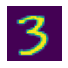

In [24]:
show_image(three_tensors[1])

In [26]:
stacked_sevens = torch.stack(seven_tensors).float() / 255
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_threes.shape # 6131 image examples of 28x28 pix resolution

torch.Size([6131, 28, 28])

In [27]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

<AxesSubplot:>

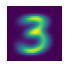

In [28]:
# 'ideal' 3 looks like
show_image(mean3)

<AxesSubplot:>

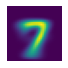

In [29]:
# 'ideal' 7 looks like
show_image(mean7)

In [30]:
single_3 = stacked_threes[1]
dist_3_abs = (single_3 - mean3).abs().mean()
dist_3_sqr = ((single_3 - mean3) ** 2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [31]:
# based on the distance we're trying to determine whether our image contains three or seven

In [32]:
dist_7_abs = (single_3 - mean7).abs().mean()
dist_7_sqr = ((single_3 - mean7) ** 2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [33]:
F.l1_loss(single_3.float(), mean7), F.mse_loss(single_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [35]:
# creating validation set
valid_3 = torch.stack(
    [tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
    
valid_3 = valid_3.float() / 255

In [36]:
valid_7 = torch.stack(
    [tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
    
valid_7 = valid_7.float() / 255

In [37]:
valid_3.shape, valid_7.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [38]:
def mnist_distance(a, b):
    return (a - b).abs().mean((-1, -2))

In [39]:
mnist_distance(single_3, mean3)

tensor(0.1114)

In [40]:
valid_3_dist = mnist_distance(valid_3, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1787, 0.1422, 0.1412,  ..., 0.1358, 0.1301, 0.1110]),
 torch.Size([1010]))

In [41]:
(valid_3 - mean3).shape

torch.Size([1010, 28, 28])

In [42]:
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [44]:
is_3(single_3), is_3(single_3).float()

(tensor(True), tensor(1.))

In [45]:
is_3(valid_3)

tensor([False,  True,  True,  ...,  True,  True,  True])

In [46]:
accuracy_3s = is_3(valid_3).float().mean()
accuracy_7s = (1 - is_3(valid_7).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_7s+accuracy_3s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [47]:
# not a bad result without using any models (just average values of pixels at the corresponding positions)

# SGD

In [48]:
# simple quadratic f
def f(x):
    return x ** 2

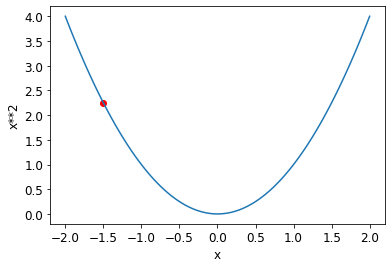

In [49]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

In [ ]:
#

# calculating gradients

In [54]:
xt = tensor(3.).requires_grad_()
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [56]:
xt.grad

In [57]:
yt.backward()

In [58]:
xt.grad

tensor(6.)

In [69]:
xt = tensor([3. , 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [70]:
def f(x):
    return (x ** 2).sum()

In [71]:
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [72]:
xt.grad

In [73]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

# end to end sgd

In [74]:
time = torch.arange(0, 20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

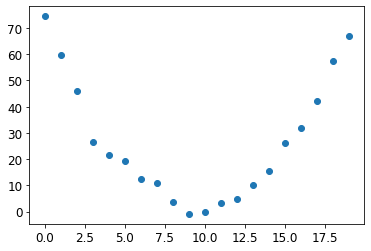

In [75]:
speed = torch.randn(20) * 3 + 0.75*(time - 9.5)**2 + 1
plt.scatter(time, speed)

In [76]:
def f(t, params):
    a, b, c = params
    return a * (t ** 2) + (b * t) + c

In [77]:
def mse(preds, targets):
    return ((preds-targets) ** 2).mean()

## step 1: init param

In [78]:
params = torch.randn(3).requires_grad_()
orig_params = params.clone()

## step 2: calculate the predictions

In [79]:
preds = f(time, params)

In [80]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

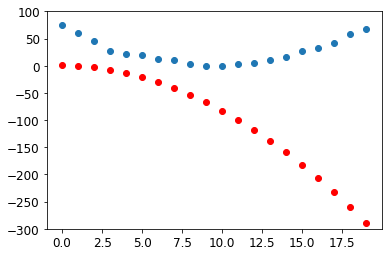

In [81]:
show_preds(preds)

## step 3: calculate the loss

In [82]:
loss = mse(preds, speed)

In [85]:
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

# step 4: calculate the gradients

In [86]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

In [87]:
params.grad * 1e-5
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

# step 5: step the weights

In [88]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

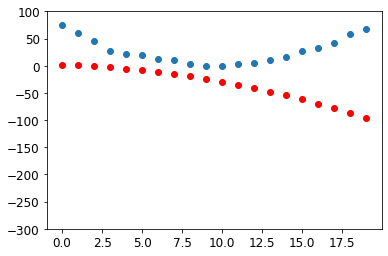

In [89]:
preds = f(time, params)
mse(preds, speed)
show_preds(preds)

In [90]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

## step 6: repeat the process

In [91]:
for i in range(10):
    apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


In [92]:
params = orig_params.detach().requires_grad_()

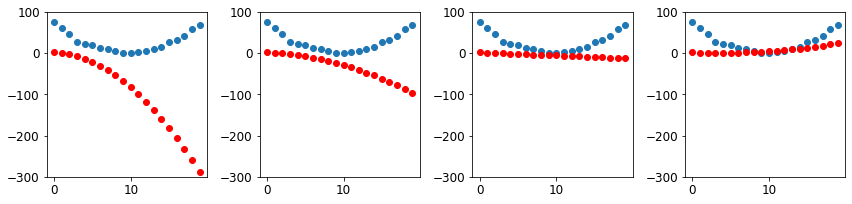

In [94]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

# the MNIST Loss Function

In [95]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0] * len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [96]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [97]:
valid_x = torch.cat([valid_3, valid_7]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_3) + [0] * len(valid_7)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [98]:
def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()

In [100]:
weights = init_params((28*28,1))
bias = init_params(1)

In [101]:
(train_x[0] * weights.T).sum() + bias

tensor([-13.2578], grad_fn=<AddBackward0>)

In [102]:
def linearl(xb):
    return xb@weights + bias
preds = linearl(train_x)
preds

tensor([[-13.2578],
        [ -4.6854],
        [-12.4631],
        ...,
        [-12.4171],
        [  2.4253],
        [  1.5262]], grad_fn=<AddBackward0>)

In [103]:
corrects = (preds > 0.0). float() == train_y
corrects.float().mean().item()

0.42739593982696533

In [104]:
with torch.no_grad():
    weights[0] *= 1.0001

In [106]:
preds = linearl(train_x)
((preds>0.0).float() == train_y).float().mean().item()


0.42739593982696533

In [107]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [108]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [110]:
torch.where(trgts==1, 1 - prds, prds)
print(mnist_loss(prds, trgts))
mnist_loss(tensor([0.9, 0.4, 0.8]), trgts)

tensor(0.4333)


tensor(0.2333)

## sigmoid

In [111]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

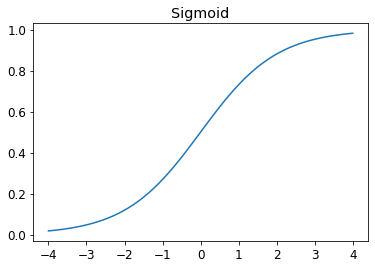

In [112]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [113]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(
        targets == 1,
        1 - predictions,
        predictions
    ).mean()

## SGD and Mini-Batches

In [114]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [115]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [116]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

## putting it all together

In [117]:
weights = init_params((28*28, 1))
bias = init_params(1)
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [118]:
valid_dl = DataLoader(valid_dset, batch_size=256)
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [119]:
preds = linearl(batch)
preds

tensor([[-6.0345],
        [ 4.8424],
        [-6.8445],
        [-5.8458]], grad_fn=<AddBackward0>)

In [120]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7504, grad_fn=<MeanBackward0>)

In [121]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0005), tensor([-0.0035]))

In [122]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [123]:
calc_grad(batch, train_y[:4], linearl)
weights.grad.mean(), bias.grad

(tensor(-0.0011), tensor([-0.0070]))

In [124]:
calc_grad(batch, train_y[:4], linearl)
weights.grad.mean(), bias.grad

(tensor(-0.0016), tensor([-0.0106]))

In [125]:
weights.grad.zero_()
bias.grad.zero_();

In [126]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [128]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [ True],
        [False],
        [False]])

In [129]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [130]:
batch_accuracy(linearl(batch), train_y[:4])

tensor(0.2500)

In [133]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [134]:
validate_epoch(linearl)

0.4044

In [140]:
lr = 1.
params = weights, bias
train_epoch(linearl, lr, params)
validate_epoch(linearl)

0.9511

In [141]:
for i in range(20):
    train_epoch(linearl, lr, params)
    print(validate_epoch(linearl), end=' ')

0.9545 0.9569 0.9584 0.9603 0.9623 0.9632 0.9637 0.9657 0.9667 0.9672 0.9677 0.9677 0.9706 0.9706 0.972 0.973 0.973 0.973 0.9725 0.9725 

# creating an optimizer

In [142]:
linear_model = nn.Linear(28*28, 1)
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [143]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [144]:
opt = BasicOptim(linear_model.parameters(), lr)

In [145]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [146]:
validate_epoch(linear_model)

0.3984

In [147]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end= ' ')

In [148]:
train_model(linear_model, 20)

0.4932 0.9033 0.8062 0.9062 0.9307 0.9453 0.9541 0.9624 0.9648 0.9673 0.9692 0.9717 0.9736 0.9751 0.9761 0.9761 0.9775 0.9775 0.9775 0.9785 

In [149]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8413 0.8433 0.9136 0.9336 0.9482 0.9555 0.9619 0.9658 0.9678 0.9702 0.9717 0.9736 0.9751 0.9761 0.9766 0.9775 0.978 0.9785 0.979 

In [150]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(
    dls, 
    nn.Linear(28*28, 1), 
    opt_func = SGD,
    loss_func = mnist_loss,
    metrics = batch_accuracy
)
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637357,0.503158,0.495584,00:00
1,0.433931,0.252359,0.767910,00:00
2,0.162974,0.162890,0.852797,00:00
3,0.073475,0.101122,0.915604,00:00
4,0.040372,0.075163,0.933268,00:00
5,0.027360,0.060706,0.949460,00:00
6,0.021948,0.051632,0.956330,00:00
7,0.019483,0.045575,0.962709,00:00
8,0.018186,0.041303,0.965653,00:00
9,0.017377,0.038142,0.968106,00:00


# Adding a Nonlinearity

In [151]:
def simple_net(xb):
    res = xb @ w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [152]:
w1 = init_params((28*28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)

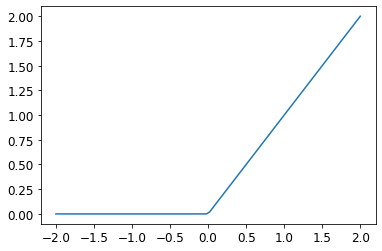

In [153]:
plot_function(F.relu)

In [154]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)
learn = Learner(
    dls,
    simple_net,
    opt_func = SGD,
    loss_func = mnist_loss,
    metrics = batch_accuracy
)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.285365,0.407872,0.504907,00:00
1,0.136580,0.216262,0.816977,00:00
2,0.077058,0.111180,0.917076,00:00
3,0.051522,0.076060,0.941609,00:00
4,0.039560,0.059735,0.956820,00:00
5,0.033371,0.050517,0.963690,00:00
6,0.029763,0.044687,0.965653,00:00
7,0.027386,0.040706,0.968106,00:00
8,0.025657,0.037810,0.969087,00:00
9,0.024312,0.035602,0.970559,00:00


In [155]:
learn.recorder.values[-1][2]

0.982826292514801

# going deeper

In [157]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(
    dls,
    resnet18,
    pretrained=False,
    loss_func = F.cross_entropy,
    metrics = accuracy
)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.105506,0.017394,0.996565,00:16
